In [1]:
import pandas as pd
import numpy as np
import flip_data
import gd_poisoner
import datetime

# Import Training, Testing and Validating Set

In [2]:
poi_train_x = pd.read_csv('train_X.csv')
print("ori train ", poi_train_x.shape[0])
poi_train_x = np.matrix(poi_train_x.to_numpy())
print("matrix train ", len(poi_train_x))
poi_train_y = pd.read_csv('train_y.csv')
print("ori train y ", poi_train_y.shape[0])
poi_train_y = poi_train_y['Life Expectancy'].tolist()
print("matrix train y ", len(poi_train_y))
poi_test_x = pd.read_csv('test_X.csv')
poi_test_x = np.matrix(poi_test_x.to_numpy())
poi_test_y = pd.read_csv('test_y.csv')
poi_test_y = poi_test_y['Life Expectancy'].tolist()
poi_val_x = pd.read_csv('val_X.csv')
poi_val_x = np.matrix(poi_val_x.to_numpy())
poi_val_y = pd.read_csv('val_y.csv')
poi_val_y = poi_val_y['Life Expectancy'].tolist()

print (poi_train_x[0])
print (poi_train_y[0])

ori train  1319
matrix train  1319
ori train y  1319
matrix train y  1319
[[2.00900000e+03 0.00000000e+00 2.52077562e-01 2.22222222e-03
  1.14221725e-01 6.87422107e-04 9.79591837e-01 9.89711711e-05
  2.10892236e-01 1.60000000e-03 9.79166667e-01 1.74114916e-01
  9.79381443e-01 0.00000000e+00 1.80413125e-03 1.54066216e-05
  5.50724638e-01 5.36842105e-01 7.75316456e-01 6.47342995e-01]]
0.6736242884250474


# Define Main Arguments

In [3]:
# num of poisoning points
poison_ct = 300
# num of points to train model
train_ct = len(poi_train_x)
test_ct = len(poi_test_x)
# proportion of poisoning
total_prop = poison_ct / (poison_ct + train_ct)
print ("Posion count: ", poison_ct, " Train count: ", train_ct, " Test count: ", test_ct, " Proportion of poisoning: ", total_prop)

Posion count:  300  Train count:  1319  Test count:  165  Proportion of poisoning:  0.1852995676343422


# Perform Inverse Flip

In [4]:
x_pois, y_pois = flip_data.flip_data.inverse_flip(poi_train_x,poi_train_y,poison_ct)

y_opp [0. 0. 0. ... 0. 0. 0.]
stats [0. 0. 0. ... 0. 0. 0.]
total_prob 132.78026565464893
x_pois len:  300
x_pois col ct: 20
y_pois len:  300


# Show Attack Result after 'flipping' and 'flipping & poisoning' on the Model

classifier:  LinearRegression()
*****************************
**** Poison Count:  51  ****
*****************************
Iteration  0 
Objective Value:  0.0061248753551509235  Change:  0.0061248753551509235
Validation MSE  0.004608461808708653 
Test MSE  0.006376423130415524
 
Iteration  1
Objective Value: 0.004685989199728606  Difference:  -0.0014388861554223177
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.004686911881539542  Difference:  -0.0014379634736113815
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.0046876364391962525  Difference:  -0.001437238915954671
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.0046881690094740785  Difference:  -0.001436706345676845
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.0046883980137507235  Difference:  -0.0014364773414002
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.004688537456246672  Difference:  -0.0014363378989042516
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.00468862149858697  Difference:  -0.001436253

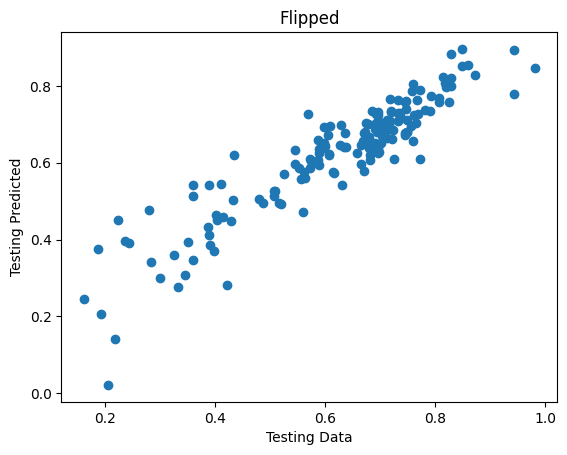

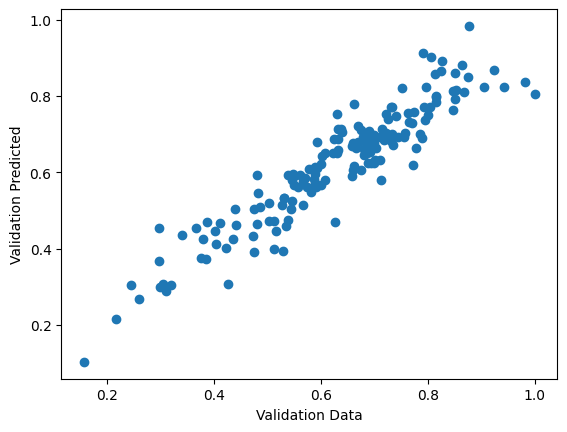

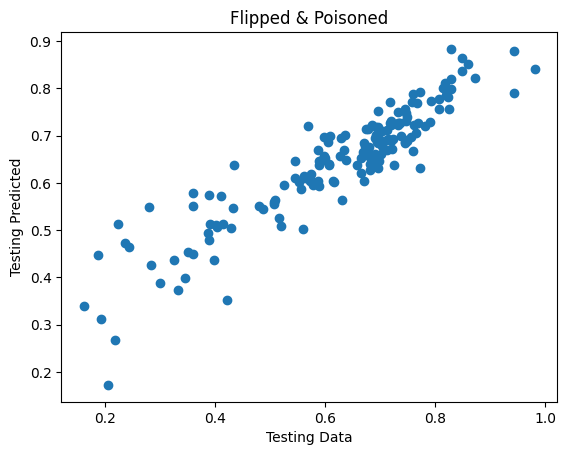

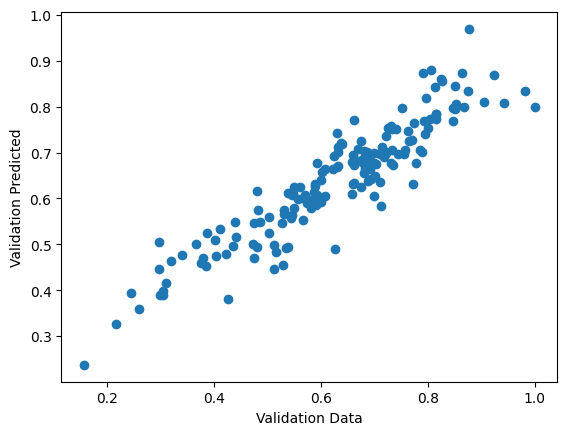

*****************************
**** Poison Count:  106  ****
*****************************
Iteration  0 
Objective Value:  0.01038425424516596  Change:  0.01038425424516596
Validation MSE  0.00865724183256403 
Test MSE  0.010959715612078667
 
Iteration  1
Objective Value: 0.004805767184700289  Difference:  -0.005578487060465671
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.0048058171145518285  Difference:  -0.005578437130614131
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.004805849614687707  Difference:  -0.005578404630478252
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.004805870759108292  Difference:  -0.005578383486057667
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.004805884511152369  Difference:  -0.00557836973401359
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.004805893453433908  Difference:  -0.0055783607917320515
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.00480589926737597  Difference:  -0.005578354977789989
NO PROGRESS MADE!
 
Iteration

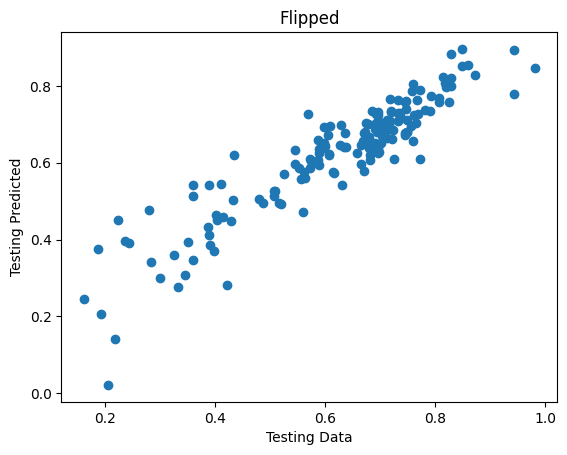

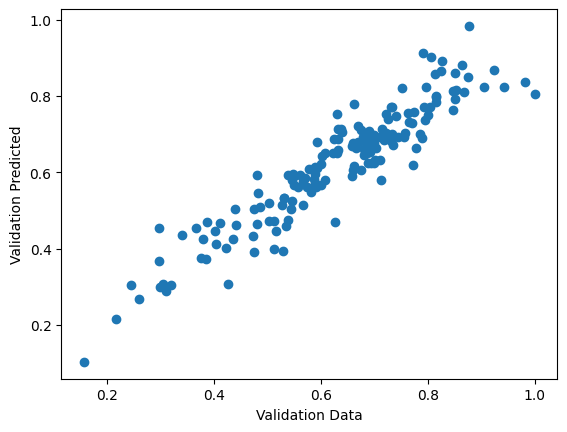

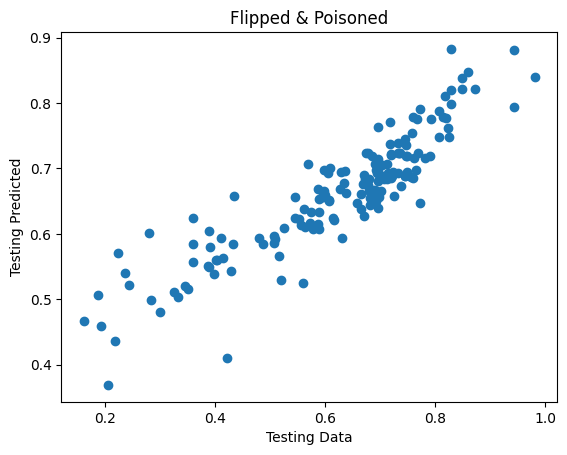

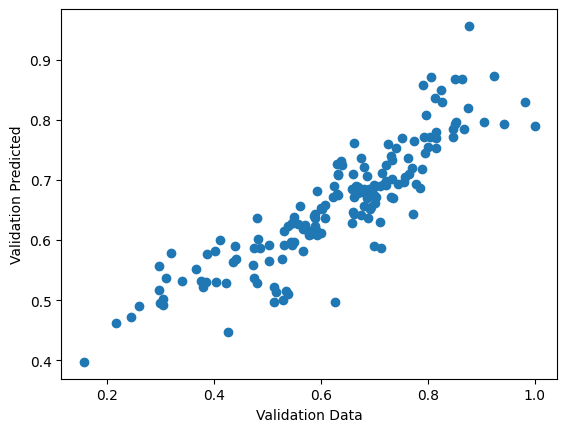

*****************************
**** Poison Count:  165  ****
*****************************
Iteration  0 
Objective Value:  0.015001451580089363  Change:  0.015001451580089363
Validation MSE  0.012941797330301085 
Test MSE  0.016245103138347174
 
Iteration  1
Objective Value: 0.004968310247255567  Difference:  -0.010033141332833796
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.004968312047275207  Difference:  -0.010033139532814156
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.0049683132173013594  Difference:  -0.010033138362788003
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.004968313977824011  Difference:  -0.010033137602265351
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.004968314472166129  Difference:  -0.010033137107923234
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.00496831479348951  Difference:  -0.010033136786599853
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.004968315002350126  Difference:  -0.010033136577739236
NO PROGRESS MADE!
 
Iterat

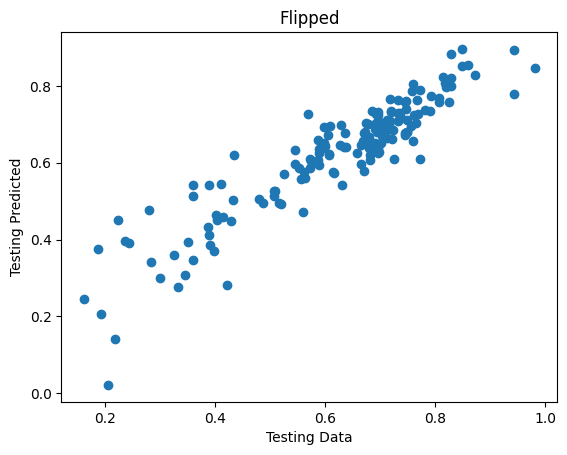

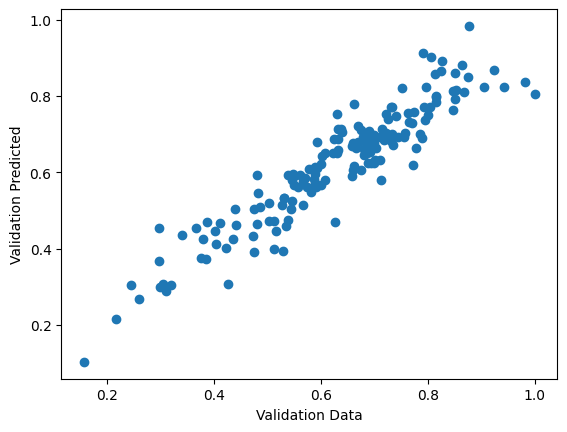

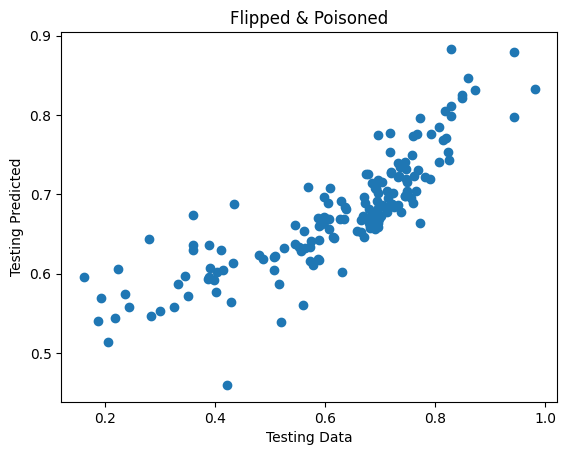

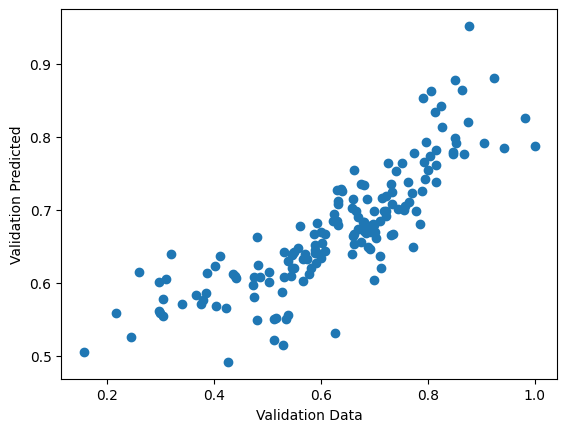

*****************************
**** Poison Count:  230  ****
*****************************
Iteration  0 
Objective Value:  0.019635879104506627  Change:  0.019635879104506627
Validation MSE  0.017373689486191297 
Test MSE  0.02063522036568887
 
Iteration  1
Objective Value: 0.005088076232170525  Difference:  -0.014547802872336101
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.005088076259432548  Difference:  -0.014547802845074079
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.0050880762771528575  Difference:  -0.01454780282735377
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.005088076288671069  Difference:  -0.014547802815835557
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.005088076296157901  Difference:  -0.014547802808348727
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.005088076301024342  Difference:  -0.014547802803482286
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.005088076304187532  Difference:  -0.014547802800319094
NO PROGRESS MADE!
 
Iterati

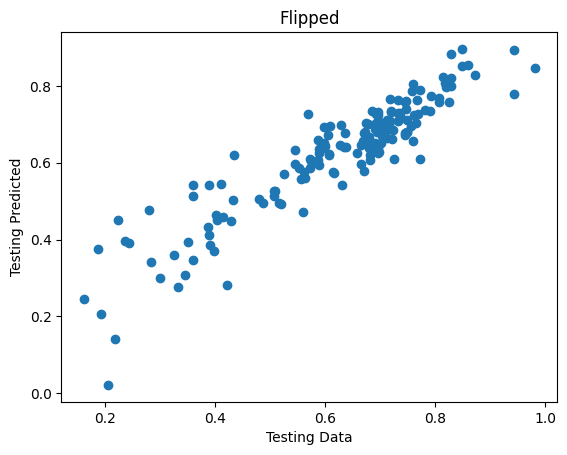

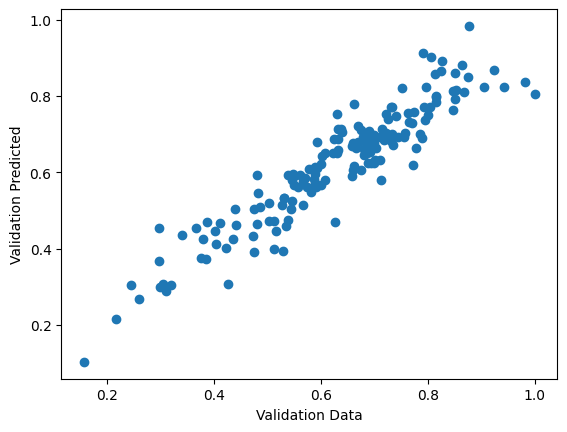

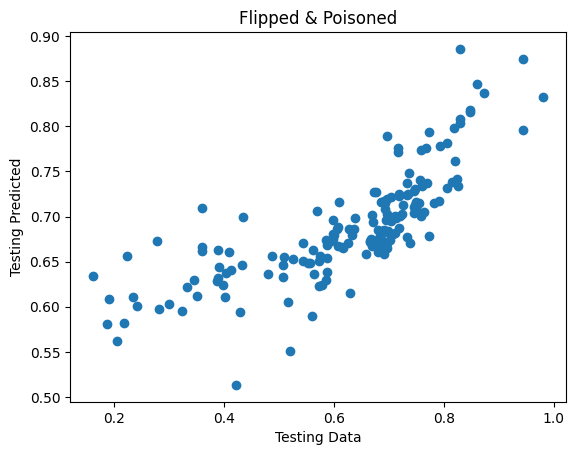

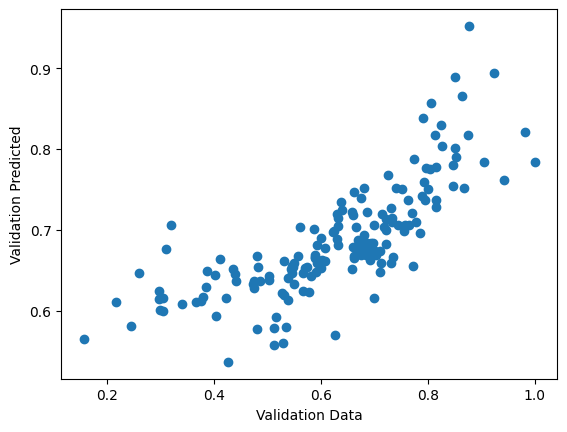

*****************************
**** Poison Count:  300  ****
*****************************
Iteration  0 
Objective Value:  0.025128784902030982  Change:  0.025128784902030982
Validation MSE  0.02271901968383527 
Test MSE  0.026066707802757414
 
Iteration  1
Objective Value: 0.005269457866851638  Difference:  -0.019859327035179345
NO PROGRESS MADE!
 
Iteration  2
Objective Value: 0.005269457867666566  Difference:  -0.019859327034364417
NO PROGRESS MADE!
 
Iteration  3
Objective Value: 0.005269457868196277  Difference:  -0.019859327033834705
NO PROGRESS MADE!
 
Iteration  4
Objective Value: 0.005269457868540584  Difference:  -0.019859327033490397
NO PROGRESS MADE!
 
Iteration  5
Objective Value: 0.005269457868764389  Difference:  -0.019859327033266594
NO PROGRESS MADE!
 
Iteration  6
Objective Value: 0.005269457868909858  Difference:  -0.019859327033121123
NO PROGRESS MADE!
 
Iteration  7
Objective Value: 0.0052694578690044075  Difference:  -0.019859327033026574
NO PROGRESS MADE!
 
Iterat

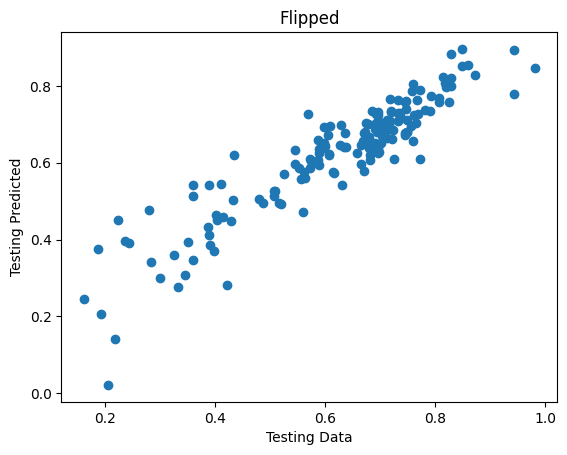

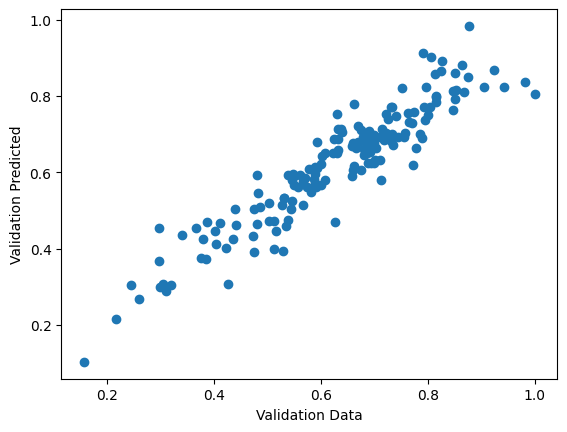

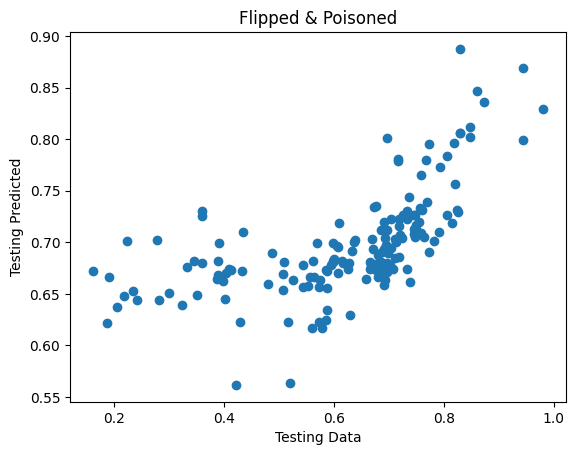

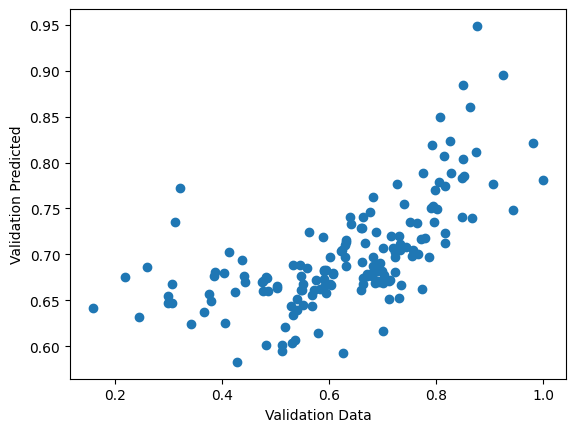


After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.02271901968383527 
 Test MSE: 0.026066707802757414


In [5]:
# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.linear_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier, False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois, 5, 10)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True,False)
    err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])

# Perform B Flip and Linear Reg Poisoning

classifier:  LinearRegression()
*****************************
**** Poison Count:  51  ****
*****************************
Iteration  0 
Objective Value:  0.005312020396083277  Change:  0.005312020396083277
Validation MSE  0.0042757679426751296 
Test MSE  0.005329422214825132
 
Iteration  1
Objective Value: 0.00643899094105241  Difference:  0.001126970544969133
 
Iteration  2
Objective Value: 0.00643899094105241  Difference:  0.0
 
Iteration  3
Objective Value: 0.00643899094105241  Difference:  0.0
 
Iteration  4
Objective Value: 0.00643899094105241  Difference:  0.0
 
Iteration  5
Objective Value: 0.00643899094105241  Difference:  0.0
 
(51, 20) (1319, 20)
x_pois_result len:  51 , y_pois_result len:  51 , x_poised len:  1370 , y_poised len:  1370
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 


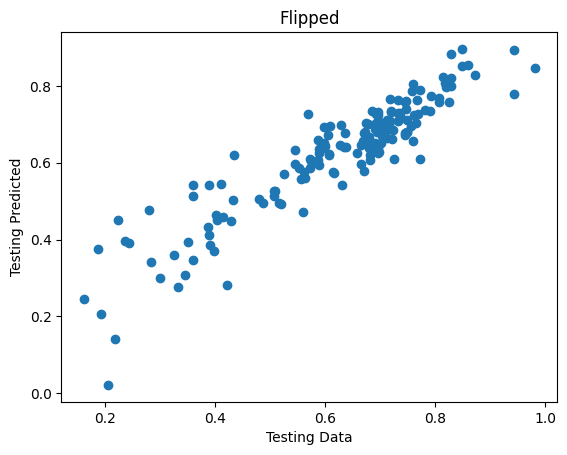

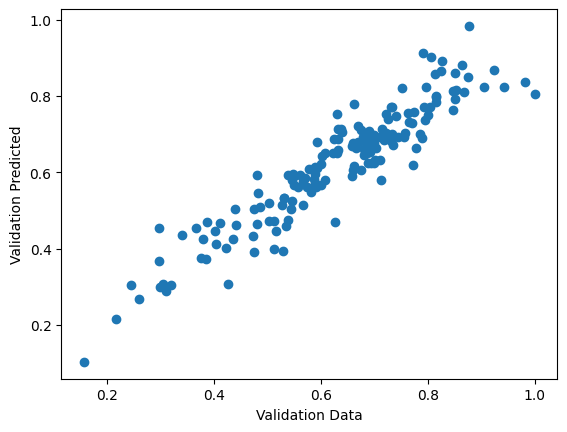

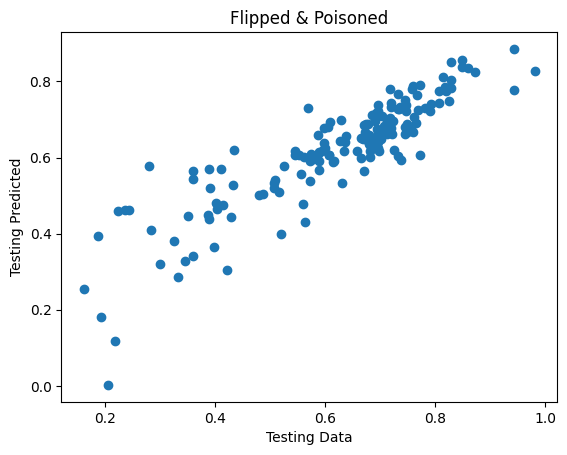

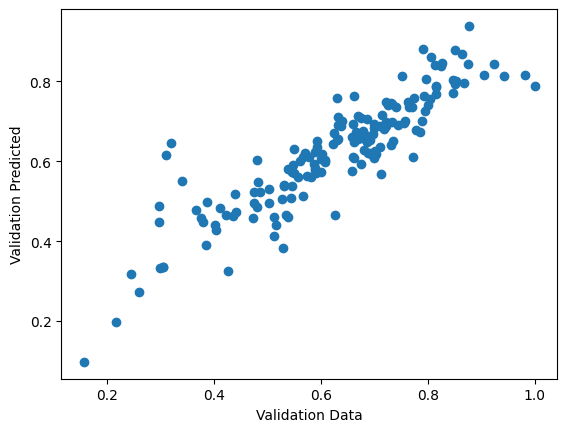

*****************************
**** Poison Count:  106  ****
*****************************
Iteration  0 
Objective Value:  0.006787677322607897  Change:  0.006787677322607897
Validation MSE  0.0059772259228244706 
Test MSE  0.0066935984973171625
 
Iteration  1
Objective Value: 0.00894332371004377  Difference:  0.002155646387435873
 
Iteration  2
Objective Value: 0.00894332371004377  Difference:  0.0
 
Iteration  3
Objective Value: 0.00894332371004377  Difference:  0.0
 
Iteration  4
Objective Value: 0.00894332371004377  Difference:  0.0
 
Iteration  5
Objective Value: 0.00894332371004377  Difference:  0.0
 
(106, 20) (1319, 20)
x_pois_result len:  106 , y_pois_result len:  106 , x_poised len:  1425 , y_poised len:  1425
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 


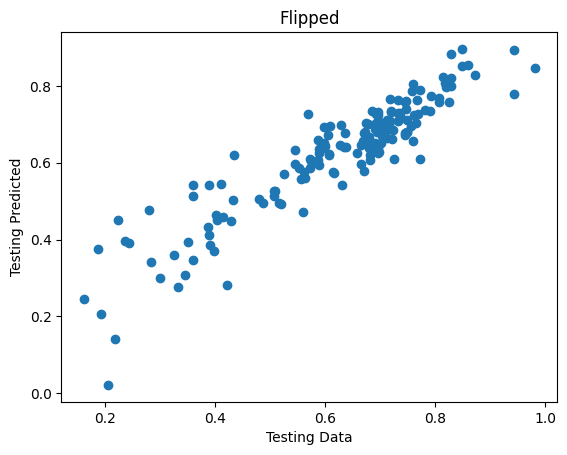

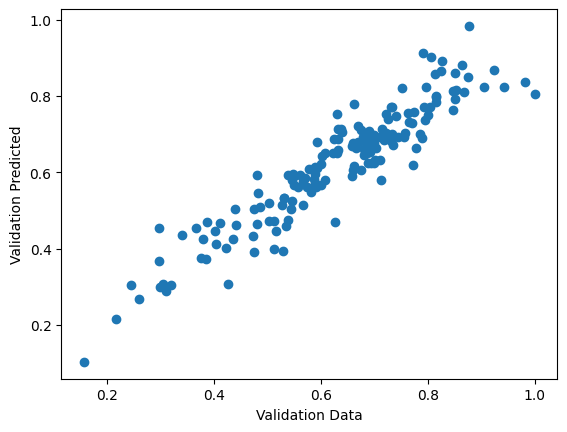

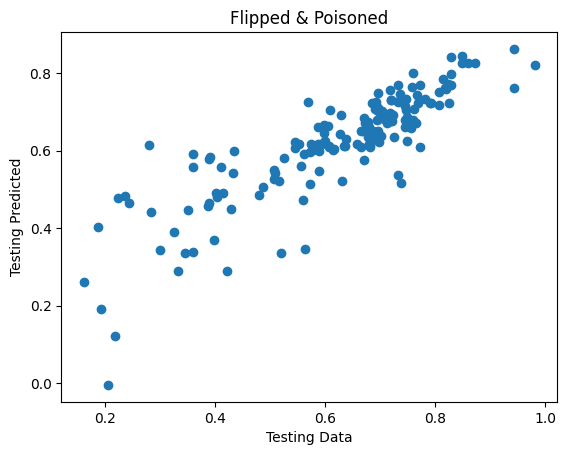

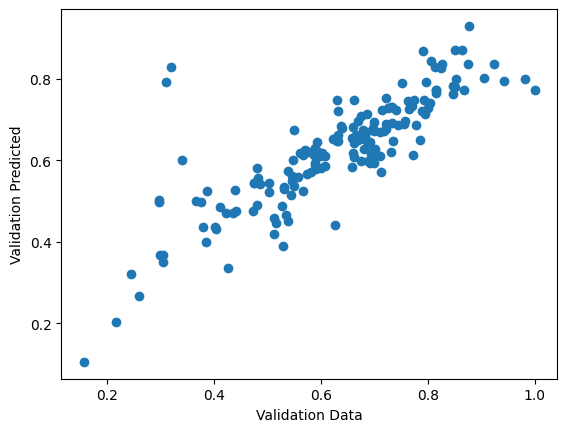

*****************************
**** Poison Count:  165  ****
*****************************
Iteration  0 
Objective Value:  0.009717489237514454  Change:  0.009717489237514454
Validation MSE  0.008967537153708693 
Test MSE  0.009446034807927287
 
Iteration  1
Objective Value: 0.011602901025090913  Difference:  0.001885411787576459
 
Iteration  2
Objective Value: 0.011602901025090913  Difference:  0.0
 
Iteration  3
Objective Value: 0.011602901025090913  Difference:  0.0
 
Iteration  4
Objective Value: 0.011602901025090913  Difference:  0.0
 
Iteration  5
Objective Value: 0.011602901025090913  Difference:  0.0
 
(165, 20) (1319, 20)
x_pois_result len:  165 , y_pois_result len:  165 , x_poised len:  1484 , y_poised len:  1484
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 


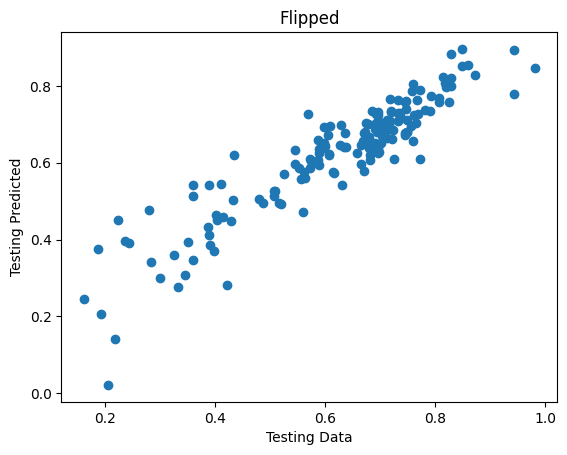

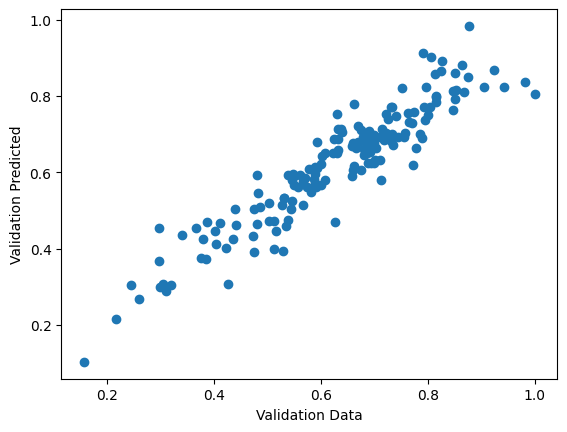

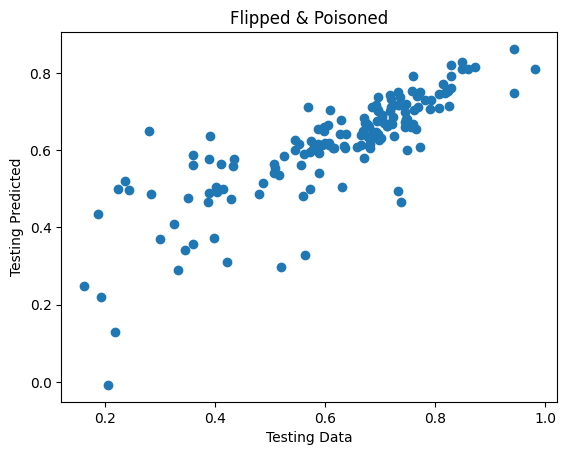

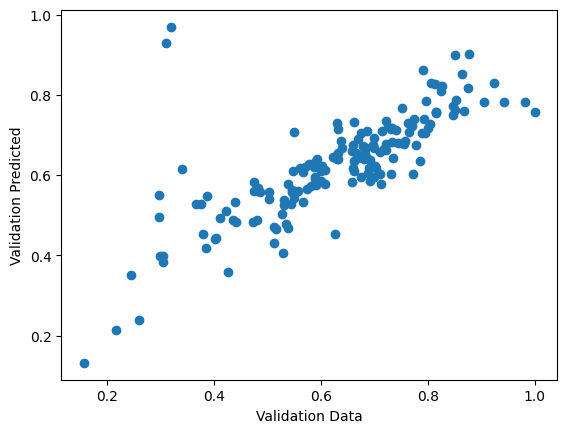

*****************************
**** Poison Count:  230  ****
*****************************
Iteration  0 
Objective Value:  0.01345792670028775  Change:  0.01345792670028775
Validation MSE  0.012481949737784985 
Test MSE  0.013218857273677201
 
Iteration  1
Objective Value: 0.015859129619905127  Difference:  0.002401202919617377
 
Iteration  2
Objective Value: 0.015859129619905127  Difference:  0.0
 
Iteration  3
Objective Value: 0.015859129619905127  Difference:  0.0
 
Iteration  4
Objective Value: 0.015859129619905127  Difference:  0.0
 
Iteration  5
Objective Value: 0.015859129619905127  Difference:  0.0
 
(230, 20) (1319, 20)
x_pois_result len:  230 , y_pois_result len:  230 , x_poised len:  1549 , y_poised len:  1549
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 


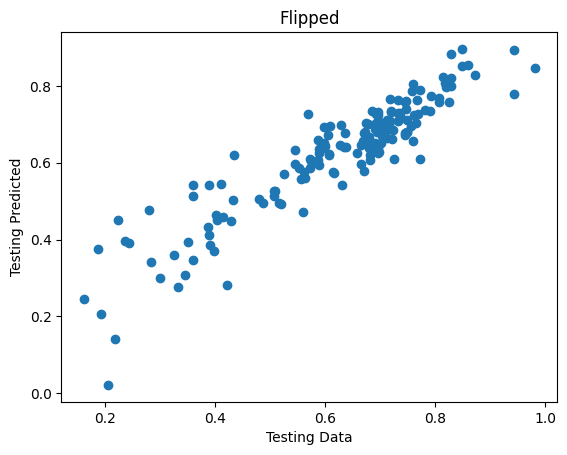

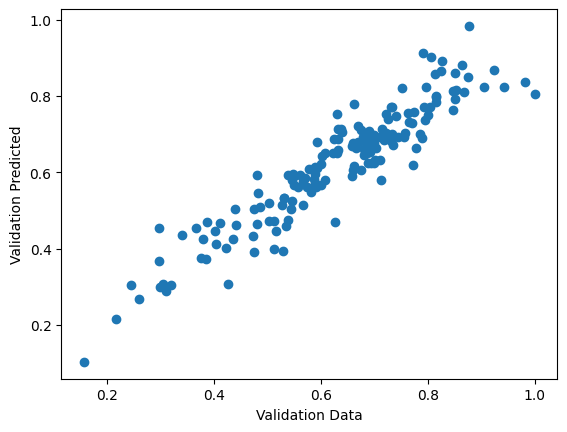

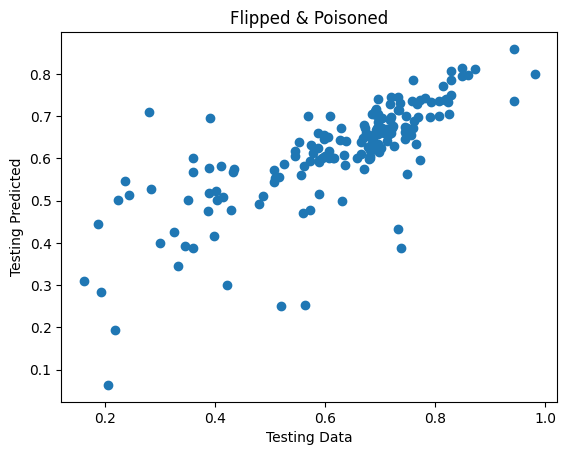

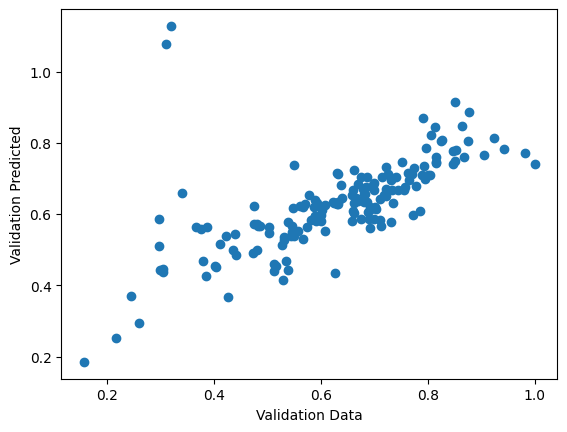

*****************************
**** Poison Count:  300  ****
*****************************
Iteration  0 
Objective Value:  0.01878299583684445  Change:  0.01878299583684445
Validation MSE  0.017683376513552746 
Test MSE  0.017955148709325474
 
Iteration  1
Objective Value: 0.019795798812312516  Difference:  0.0010128029754680641
 
Iteration  2
Objective Value: 0.019795798812312516  Difference:  0.0
 
Iteration  3
Objective Value: 0.019795798812312516  Difference:  0.0
 
Iteration  4
Objective Value: 0.019795798812312516  Difference:  0.0
 
Iteration  5
Objective Value: 0.019795798812312516  Difference:  0.0
 
(300, 20) (1319, 20)
x_pois_result len:  300 , y_pois_result len:  300 , x_poised len:  1619 , y_poised len:  1619
classifier_poised  LinearRegression() , classifier2  LinearRegression()
 


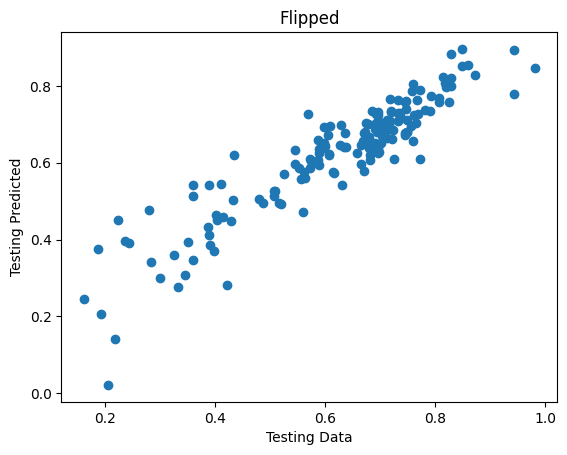

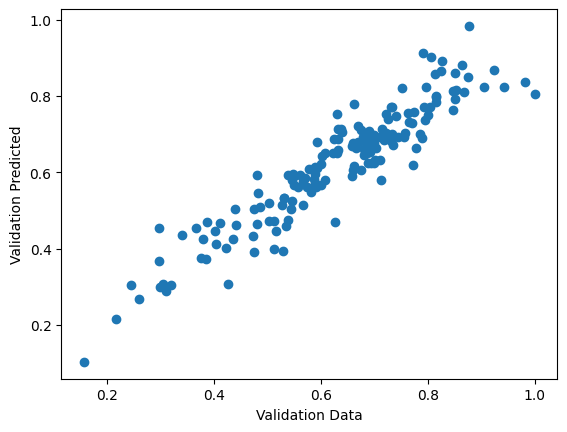

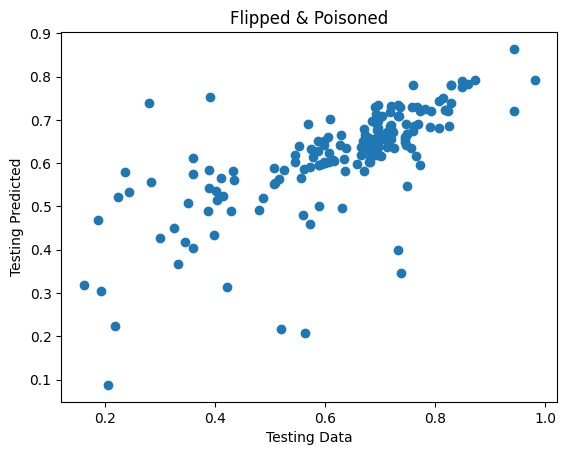

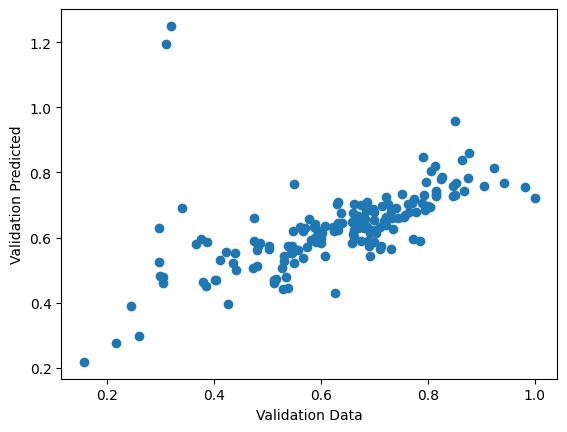


After Flipping, Unpoisoned 
 Validation MSE:  0.0035266882948545124 
 Test MSE: 0.00452093145874648

After Flipping & Poisoning:
 Validation MSE:  0.01941061089908537 
 Test MSE: 0.014188431087216916


In [6]:
x_pois, y_pois = flip_data.flip_data.B_flip(poi_train_x,poi_train_y,poison_ct)

# define parameters for poisoner
eta = 0.01 # gradient descent step size (note gradients are normalized)
beta = 0.05 # decay rate for line search
sigma = 0.9 # line search stop condition
epsilon = 1e-3 # poisoning stop condition
poiser = gd_poisoner.linear_poisoner(poi_train_x, poi_train_y, poi_test_x, poi_test_y, poi_val_x, poi_val_y, eta, beta, sigma, epsilon)
classifier, _ = poiser.learn_model(np.concatenate((poi_train_x, x_pois), axis=0), poi_train_y + y_pois, None)
print("classifier: ", classifier)
err = poiser.compute_error(classifier, False,False)[0]
x_pois = np.matrix(x_pois)
y_pois = y_pois[:]
for i in  range(5):
    # calculate the amt of data that should be poisoned in this iteration
    current_prop = (i + 1)*total_prop/5
    sample_amt = int(0.5 + train_ct*(current_prop/(1 - current_prop)))
    current_x_pois = x_pois[:sample_amt,:]
    current_y_pois = y_pois[:sample_amt]
    # poison data
    x_pois_result, y_pois_result = poiser.poison_data(current_x_pois, current_y_pois, 5, 10)
    print(x_pois_result.shape,poi_train_x.shape)
    x_poised = np.concatenate((poi_train_x,x_pois_result),axis = 0)
    y_poised = poi_train_y + y_pois_result
    # train the model on poisoned data
    classifier_poised, _ = poiser.learn_model(x_poised,y_poised,None)
    classifier = poiser.init_classifier
    print("x_pois_result len: ",len(x_pois_result),", y_pois_result len: ",len(y_pois_result),", x_poised len: ",len(x_poised),", y_poised len: ",len(y_poised))
    print("classifier_poised ",classifier_poised,", classifier2 ",classifier)
    print(" ")
    err_unpoised = poiser.compute_error(classifier,True,False)
    err = poiser.compute_error(classifier_poised,True,True)

print("\nAfter Flipping, Unpoisoned \n Validation MSE: ", err_unpoised[0], "\n Test MSE:", err_unpoised[1])
print("\nAfter Flipping & Poisoning:\n Validation MSE: ", err[0], "\n Test MSE:", err[1])